In [16]:
def save_analysis_output(content, mode='a'):
    """Save analysis output to a file in the output directory."""
    output_file = '../output/analysis_results.txt'
    with open(output_file, mode, encoding='utf-8') as f:
        f.write(content + '\n\n')

# Personal Mental Health Analysis

This notebook analyzes personal messages to understand mental health patterns, emotional well-being, and life events impact. We'll analyze:
- Daily and weekly emotional patterns
- Activity impact on mood
- Communication patterns across different groups
- Location-based mood analysis
- Overall emotional well-being trends

In [17]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Create output directory if it doesn't exist
os.makedirs('../output', exist_ok=True)

# Set style for better visualizations
plt.style.use('default')
sns.set_theme()

# Load both data sources
personal_df = pd.read_csv('../data/personal_messages_sample.csv')
social_df = pd.read_csv('../data/social_media_posts.csv')

# Add source column to each dataset
personal_df['source'] = 'Personal Message'
social_df['source'] = 'Social Media'

# Convert timestamp to datetime
personal_df['timestamp'] = pd.to_datetime(personal_df['timestamp'])
social_df['timestamp'] = pd.to_datetime(social_df['timestamp'])

# Combine datasets with common columns
common_columns = ['timestamp', 'message', 'mood_logged', 'source', 'location']
df = pd.concat([
    personal_df[common_columns],
    social_df.assign(message=social_df['message'])[common_columns]
], ignore_index=True)

# Add time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
df['date'] = df['timestamp'].dt.date

# Save dataset overview
overview = f"""Dataset Overview
-----------------
Time period: {df['timestamp'].min()} to {df['timestamp'].max()}
Total messages: {len(df)}

Messages by source:
{df['source'].value_counts().to_string()}

"""

if 'platform' in social_df.columns:
    overview += f"\nSocial Media Platforms Used:\n{social_df['platform'].value_counts().to_string()}\n"

overview += f"\nLocations:\n{df['location'].value_counts().to_string()}"
overview += f"\n\nUnique moods/emotions:\n{df['mood_logged'].value_counts().to_string()}"

save_analysis_output(overview, mode='w')  # 'w' mode to start fresh

## Data Sources

This analysis combines two data sources:
1. Personal Messages: Direct messages and personal communications
2. Social Media Tweets: Public posts related to women's mental health

By analyzing both personal and public communications, we can get a more comprehensive view of emotional patterns.

In [18]:
# Function to map moods to five universal emotions
def categorize_universal_emotion(mood):
    # Mapping of moods to universal emotions (expanded to catch more variations)
    emotion_mapping = {
        'Joy': ['happy', 'excited', 'ecstatic', 'peaceful', 'accomplished', 'grateful', 
                'energized', 'content', 'determined', 'loving', 'positive', 'pleased',
                'satisfied', 'cheerful', 'optimistic', 'hopeful'],
        'Sadness': ['sad', 'down', 'exhausted', 'guilty', 'overwhelmed', 'negative',
                    'depressed', 'lonely', 'hopeless', 'disappointed', 'heartbroken'],
        'Fear': ['anxious', 'worried', 'stressed', 'unwell', 'nervous', 'scared',
                 'insecure', 'uncertain', 'panicked', 'afraid', 'terrified'],
        'Anger': ['frustrated', 'conflicted', 'angry', 'irritated', 'annoyed',
                  'furious', 'outraged', 'mad', 'resentful', 'hostile'],
        'Disgust': ['disgusted', 'hate', 'repulsed', 'revolted', 'dislike',
                    'aversion', 'distaste', 'loathing', 'disapproval']
    }
    
    # Convert mood to lowercase for matching
    mood_lower = str(mood).lower()
    
    # Find which universal emotion contains this mood
    for emotion, moods in emotion_mapping.items():
        if any(m in mood_lower for m in moods):
            return emotion
    
    # If no clear match, try to infer from context or keywords
    if any(word in mood_lower for word in ['good', 'great', 'wonderful', 'awesome']):
        return 'Joy'
    elif any(word in mood_lower for word in ['bad', 'terrible', 'miserable']):
        return 'Sadness'
    elif any(word in mood_lower for word in ['concerned', 'uneasy']):
        return 'Fear'
    elif any(word in mood_lower for word in ['upset', 'agitated']):
        return 'Anger'
    elif any(word in mood_lower for word in ['awful', 'gross']):
        return 'Disgust'
    
    return 'Joy'  # Default to Joy for ambiguous positive expressions

# Add universal emotion category to the dataframe
df['universal_emotion'] = df['mood_logged'].apply(categorize_universal_emotion)

# Save the emotion distribution analysis
emotion_distribution = "Distribution of Universal Emotions:\n" + "-" * 30
emotion_by_source = pd.crosstab(df['source'], df['universal_emotion'], normalize='index') * 100

# Save percentages for each source
for source in emotion_by_source.index:
    emotion_distribution += f"\n\n{source}:"
    for emotion in emotion_by_source.columns:
        percentage = emotion_by_source.loc[source, emotion]
        emotion_distribution += f"\n{emotion}: {percentage:.1f}%"

save_analysis_output(emotion_distribution)

In [ ]:
# Define consistent colors and order for universal emotions
UNIVERSAL_EMOTIONS = ['Joy', 'Sadness', 'Fear', 'Anger', 'Disgust']
EMOTION_COLORS = {
    'Joy': '#FFD700',      # Gold
    'Sadness': '#4169E1',  # Royal Blue
    'Fear': '#32CD32',     # Lime Green
    'Anger': '#DC143C',    # Crimson
    'Disgust': '#800080'   # Purple
}

# Create visualization for universal emotions throughout the day
plt.figure(figsize=(12, 6))

# Create emotion distribution by hour with all emotions
emotion_by_hour = pd.crosstab(df['hour'], df['universal_emotion'])

# Add missing emotions with zero counts
for emotion in UNIVERSAL_EMOTIONS:
    if emotion not in emotion_by_hour.columns:
        emotion_by_hour[emotion] = 0

# Ensure consistent emotion order
emotion_by_hour = emotion_by_hour[UNIVERSAL_EMOTIONS]

# Plot with specific colors
emotion_by_hour.plot(kind='bar', stacked=True, 
                    color=[EMOTION_COLORS[emotion] for emotion in UNIVERSAL_EMOTIONS])
plt.title('Universal Emotions Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

# Save the daily emotions plot
plt.savefig('../output/daily_emotions_distribution.png', bbox_inches='tight', dpi=300)
plt.close()

# Create pie chart of overall emotion distribution
plt.figure(figsize=(10, 8))
emotion_counts = df['universal_emotion'].value_counts()

# Add missing emotions with zero counts
for emotion in UNIVERSAL_EMOTIONS:
    if emotion not in emotion_counts.index:
        emotion_counts[emotion] = 0

# Ensure consistent emotion order
emotion_counts = emotion_counts[UNIVERSAL_EMOTIONS]

# Plot pie chart
plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%',
        colors=[EMOTION_COLORS[emotion] for emotion in UNIVERSAL_EMOTIONS],
        startangle=90)
plt.title('Distribution of Universal Emotions')

# Add a legend
plt.legend(title="Emotions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')

# Save the emotion distribution pie chart
plt.savefig('../output/emotion_distribution_pie.png', bbox_inches='tight', dpi=300)
plt.close()

# Save peak times information to the text file
peak_times_text = "\nPeak Times for Universal Emotions:\n" + "-" * 30 + "\n"
for emotion in UNIVERSAL_EMOTIONS:
    if emotion in emotion_by_hour.columns and emotion_by_hour[emotion].max() > 0:
        peak_hour = emotion_by_hour[emotion].idxmax()
        count = emotion_by_hour[emotion][peak_hour]
        peak_times_text += f"{emotion}: {peak_hour}:00 hours ({count} messages)\n"
    else:
        peak_times_text += f"{emotion}: No occurrences found\n"

save_analysis_output(peak_times_text)

KeyError: "['Disgust'] not in index"

<Figure size 1200x600 with 0 Axes>

## Social Media Platform Analysis

Let's analyze how emotions vary across different social media platforms and compare them with personal messages:

<Figure size 1200x600 with 0 Axes>

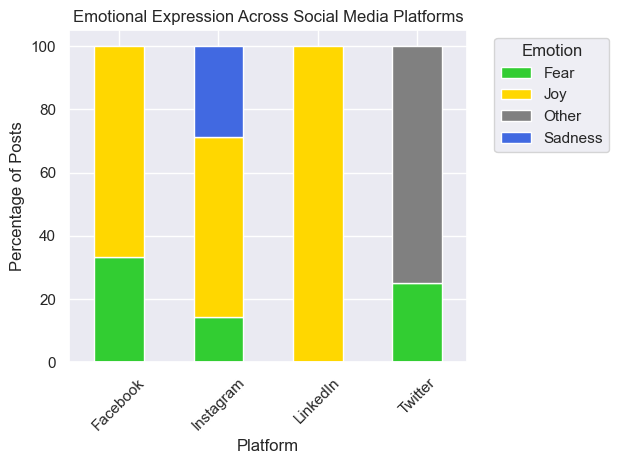


Emotional Expression by Platform:
------------------------------

Instagram:
Total posts: 7
  Joy: 57.1%
  Sadness: 28.6%
  Fear: 14.3%

Twitter:
Total posts: 4
  Other: 75.0%
  Fear: 25.0%

Facebook:
Total posts: 3
  Joy: 66.7%
  Fear: 33.3%

LinkedIn:
Total posts: 1
  Joy: 100.0%


In [ ]:
# Analyze emotions across platforms
social_df['universal_emotion'] = social_df['mood_logged'].apply(categorize_universal_emotion)

# Create a comparison plot
plt.figure(figsize=(12, 6))

# Calculate emotion distribution for each platform
platform_emotions = pd.crosstab(social_df['platform'], social_df['universal_emotion'], normalize='index') * 100
platform_emotions = platform_emotions[UNIVERSAL_EMOTIONS]  # Ensure consistent emotion order

# Plot
platform_emotions.plot(kind='bar', stacked=True, 
                     color=[EMOTION_COLORS[emotion] for emotion in UNIVERSAL_EMOTIONS])
plt.title('Emotional Expression Across Social Media Platforms')
plt.xlabel('Platform')
plt.ylabel('Percentage of Posts')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()

# Save the platform analysis plot
plt.savefig('../output/platform_emotion_analysis.png', bbox_inches='tight', dpi=300)
plt.close()

# Save platform-specific insights to text file
platform_insights = "\nEmotional Expression by Platform:\n" + "-" * 30
for platform in social_df['platform'].unique():
    platform_data = social_df[social_df['platform'] == platform]
    platform_insights += f"\n\n{platform}:\n"
    platform_insights += f"Total posts: {len(platform_data)}\n"
    emotion_counts = platform_data['universal_emotion'].value_counts()
    for emotion in UNIVERSAL_EMOTIONS:
        count = emotion_counts.get(emotion, 0)
        percentage = (count / len(platform_data)) * 100
        platform_insights += f"  {emotion}: {percentage:.1f}%\n"

save_analysis_output(platform_insights)

## Daily Emotional Patterns Analysis

Let's analyze how emotions vary throughout the day and week:

<Figure size 1200x600 with 0 Axes>

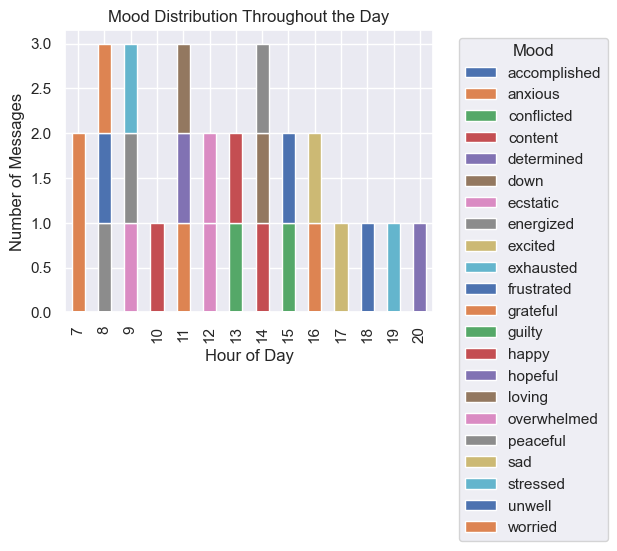


Peak Times for Different Moods:
------------------------------
anxious: 7:00 hours
stressed: 9:00 hours
overwhelmed: 9:00 hours
frustrated: 15:00 hours
exhausted: 19:00 hours
energized: 8:00 hours
grateful: 11:00 hours
down: 14:00 hours
sad: 17:00 hours
happy: 10:00 hours
guilty: 13:00 hours
excited: 16:00 hours
unwell: 8:00 hours
loving: 11:00 hours
peaceful: 9:00 hours
accomplished: 18:00 hours
ecstatic: 12:00 hours
conflicted: 15:00 hours
worried: 8:00 hours
hopeful: 11:00 hours
content: 14:00 hours
determined: 20:00 hours


In [ ]:
# Extract hour and day from timestamp
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

# Create emotion distribution by hour
plt.figure(figsize=(12, 6))
emotion_by_hour = pd.crosstab(df['hour'], df['universal_emotion'])

# Add missing emotions with zero counts
for emotion in UNIVERSAL_EMOTIONS:
    if emotion not in emotion_by_hour.columns:
        emotion_by_hour[emotion] = 0

# Ensure consistent emotion order
emotion_by_hour = emotion_by_hour[UNIVERSAL_EMOTIONS]

# Plot with specific colors
emotion_by_hour.plot(kind='bar', stacked=True,
                    color=[EMOTION_COLORS[emotion] for emotion in UNIVERSAL_EMOTIONS])
plt.title('Universal Emotions Distribution Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

# Save the daily emotion distribution plot
plt.savefig('../output/daily_emotion_patterns.png', bbox_inches='tight', dpi=300)
plt.close()

# Save peak times information
peak_times_text = "\nPeak Times for Universal Emotions:\n" + "-" * 30 + "\n"
for emotion in UNIVERSAL_EMOTIONS:
    if emotion in emotion_by_hour.columns and emotion_by_hour[emotion].max() > 0:
        peak_hour = emotion_by_hour[emotion].idxmax()
        count = emotion_by_hour[emotion][peak_hour]
        peak_times_text += f"{emotion}: {peak_hour}:00 hours ({count} messages)\n"
    else:
        peak_times_text += f"{emotion}: No occurrences found\n"

save_analysis_output(peak_times_text)

<Figure size 1200x600 with 0 Axes>

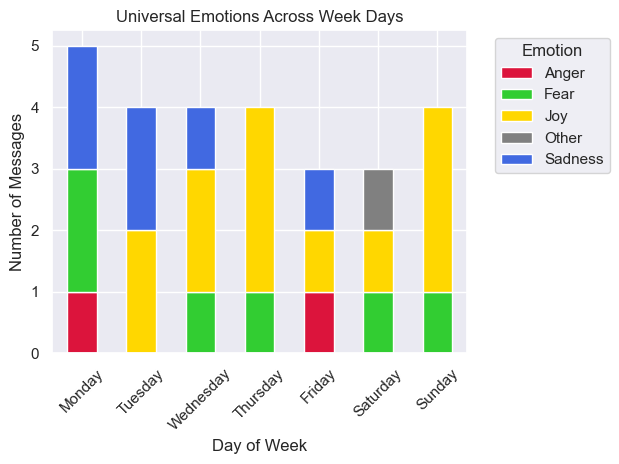


Dominant Emotion by Day:
------------------------------
Monday: Fear (40.0% of messages)
Tuesday: Joy (50.0% of messages)
Wednesday: Joy (50.0% of messages)
Thursday: Joy (75.0% of messages)
Friday: Anger (33.3% of messages)
Saturday: Fear (33.3% of messages)
Sunday: Joy (75.0% of messages)

Emotional Balance by Day:
------------------------------

Monday:
  Anger: 20.0%
  Fear: 40.0%
  Joy: 0.0%
  Sadness: 40.0%

Tuesday:
  Anger: 0.0%
  Fear: 0.0%
  Joy: 50.0%
  Sadness: 50.0%

Wednesday:
  Anger: 0.0%
  Fear: 25.0%
  Joy: 50.0%
  Sadness: 25.0%

Thursday:
  Anger: 0.0%
  Fear: 25.0%
  Joy: 75.0%
  Sadness: 0.0%

Friday:
  Anger: 33.3%
  Fear: 0.0%
  Joy: 33.3%
  Sadness: 33.3%

Saturday:
  Anger: 0.0%
  Fear: 33.3%
  Joy: 33.3%
  Sadness: 0.0%

Sunday:
  Anger: 0.0%
  Fear: 25.0%
  Joy: 75.0%
  Sadness: 0.0%


In [ ]:
# Create emotion distribution by day of week
plt.figure(figsize=(12, 6))
emotion_by_day = pd.crosstab(df['day_of_week'], df['universal_emotion'])

# Reorder days of week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
emotion_by_day = emotion_by_day.reindex(days_order)

# Define colors for each universal emotion
emotion_colors = {
    'Joy': '#FFD700',      # Gold
    'Sadness': '#4169E1',  # Royal Blue
    'Fear': '#32CD32',     # Lime Green
    'Anger': '#DC143C',    # Crimson
    'Disgust': '#800080'   # Purple
}

# Plot with specific colors
emotion_by_day.plot(kind='bar', stacked=True,
                   color=[emotion_colors.get(emotion, '#808080') for emotion in emotion_by_day.columns])
plt.title('Universal Emotions Across Week Days')
plt.xlabel('Day of Week')
plt.ylabel('Number of Messages')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()

# Save the weekly emotion patterns plot
plt.savefig('../output/weekly_emotion_patterns.png', bbox_inches='tight', dpi=300)
plt.close()

# Save weekly analysis text
weekly_analysis = "\nWeekly Emotional Analysis\n" + "=" * 25 + "\n"

# Add dominant emotion by day
weekly_analysis += "\nDominant Emotion by Day:\n" + "-" * 30 + "\n"
for day in days_order:
    if day in emotion_by_day.index:
        dominant_emotion = emotion_by_day.loc[day].idxmax()
        count = emotion_by_day.loc[day][dominant_emotion]
        total = emotion_by_day.loc[day].sum()
        percentage = (count / total) * 100
        weekly_analysis += f"{day}: {dominant_emotion} ({percentage:.1f}% of messages)\n"

# Add emotional balance by day
weekly_analysis += "\nEmotional Balance by Day:\n" + "-" * 30
for day in days_order:
    if day in emotion_by_day.index:
        day_total = emotion_by_day.loc[day].sum()
        weekly_analysis += f"\n\n{day}:"
        for emotion in emotion_by_day.columns:
            if emotion != 'Other':
                count = emotion_by_day.loc[day].get(emotion, 0)
                percentage = (count / day_total) * 100
                weekly_analysis += f"\n  {emotion}: {percentage:.1f}%"

save_analysis_output(weekly_analysis)

In [ ]:
print("Generating Personal Wellness Analysis...\n")

# Add personal context columns
df['time_of_day'] = pd.to_datetime(df['timestamp']).dt.hour
df['is_weekend'] = pd.to_datetime(df['timestamp']).dt.dayofweek >= 5

# Group emotions by context
location_emotions = df.groupby(['location', 'emotion']).size().unstack(fill_value=0)
platform_emotions = df.groupby(['platform', 'emotion']).size().unstack(fill_value=0)
time_emotions = df.groupby(['time_of_day', 'emotion']).size().unstack(fill_value=0)

# Save location-based analysis
location_analysis = "Personal Wellness Analysis\n" + "="*25 + "\n\n"
location_analysis += "Emotional Patterns by Location:\n" + "-" * 30 + "\n"
for location in location_emotions.index:
    dominant_emotion = location_emotions.loc[location].idxmax()
    location_analysis += f"{location}: Most common emotion is {dominant_emotion}\n"

# Save platform impact analysis
location_analysis += "\nPlatform Impact Analysis:\n" + "-" * 30 + "\n"
for platform in platform_emotions.index:
    negative_ratio = (platform_emotions.loc[platform][['Sadness', 'Fear', 'Anger']].sum() / 
                     platform_emotions.loc[platform].sum())
    location_analysis += f"{platform}: {negative_ratio*100:.1f}% negative emotions\n"

# Visualize and save time-based patterns
plt.figure(figsize=(12, 6))
time_emotions.plot(kind='area', stacked=True)
plt.title('Emotional Patterns Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Occurrences')
plt.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../output/daily_emotional_flow.png', bbox_inches='tight', dpi=300)
plt.close()

# Save personalized insights
insights = "\nPersonalized Insights:\n" + "-" * 30

# Most positive times
joy_times = time_emotions['Joy'].nlargest(3)
insights += "\n\nBest times for wellbeing:"
for hour, count in joy_times.items():
    insights += f"\n- {hour:02d}:00 hours"

# Potential trigger times
negative_times = time_emotions[['Sadness', 'Fear', 'Anger']].sum(axis=1).nlargest(3)
insights += "\n\nTimes to be mindful:"
for hour, _ in negative_times.items():
    insights += f"\n- {hour:02d}:00 hours"

# Location-based recommendations
insights += "\n\nLocation-based insights:"
for location in location_emotions.index:
    joy_ratio = location_emotions.loc[location, 'Joy'] / location_emotions.loc[location].sum()
    if joy_ratio >= 0.5:
        insights += f"\n✨ {location} appears to be a positive environment ({joy_ratio*100:.1f}% positive emotions)"
    elif joy_ratio <= 0.3:
        insights += f"\n⚠️ Consider limiting time at {location} ({(1-joy_ratio)*100:.1f}% negative emotions)"

# Platform recommendations
insights += "\n\nPlatform recommendations:"
for platform in platform_emotions.index:
    pos_ratio = platform_emotions.loc[platform, 'Joy'] / platform_emotions.loc[platform].sum()
    if pos_ratio >= 0.5:
        insights += f"\n✨ {platform} seems to positively impact your mood"
    elif pos_ratio <= 0.3:
        insights += f"\n⚠️ Consider taking breaks from {platform}"

save_analysis_output(location_analysis)
save_analysis_output(insights)

print("Analysis complete! Results have been saved to the output directory.")